<a href="https://colab.research.google.com/github/priya-sakshi/Classification-/blob/master/Building_Generative_Adversarial_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A generative adversarial network (GAN) has two parts:

1. The generator learns to generate plausible data. The generated instances become negative training examples for the discriminator.

2. The discriminator learns to distinguish the generator's fake data from real data. The discriminator penalizes the generator for producing implausible results.


Goodfellow made an analogy that explains the dynamic present in the GAN models:

"The generative model can be thought of as analogous to a team of counterfeiters, trying to produce fake currency and use it without detection, while the discriminative model is analogous to the police, trying to detect the counterfeit currency. Competition in this game drives both teams to improve their methods until the counterfeits are indistinguishable from the genuine articles."


In [ ]:
#Ensure this is running on GPU change the runtime type
import torch
import numpy as np
import matplotlib.pyplot as plt

###PyTorch
PyTorch is a fully featured framework for building deep learning models, which is a type of machine learning that’s commonly used in applications like image recognition and language processing. Written in Python, it’s relatively easy for most machine learning developers to learn and use.

###Tensors

Tensors are a core PyTorch data type, similar to a multidimensional array, used to store and manipulate the inputs and outputs of a model, as well as the model’s parameters. Tensors are similar to NumPy’s ndarrays, except that tensors can run on GPUs to accelerate computing.

###GPUs

Architecturally, the CPU is composed of just a few cores with lots of cache memory that can handle a few software threads at a time. In contrast, a GPU is composed of hundreds of cores that can handle thousands of threads simultaneously.

In [ ]:
#Configurations
#utilize GPUs for computation
device='cuda'
batch_size=64

#used in generator model
noise_dim=64

#optimizer parameters
lr=0.0002
beta_1=0.5
beta_2=0.99

#Training variable
epochs=20


#Load MNIST dataset



In [ ]:
#The torchvision package consists of popular datasets, model architectures, and common image transformations for computer vision.
from torchvision import datasets, transforms as T

#Transforms are common image transformations available in the torchvision.transforms module. They can be chained together using Compose.
train_augs = T.Compose([
                        T.RandomRotation((-20, 20)),
                        T.ToTensor()
])


In [ ]:
#CLASS torchvision.datasets.MNIST(root: str, train: bool = True, transform: Optional[Callable] = None,
#                               target_transform: Optional[Callable] = None, download: bool = False)

trainset = datasets.MNIST('MNIST/', download=True, train=True, transform=train_augs)

100%|██████████| 9912422/9912422 [00:00<00:00, 93559126.88it/s]


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 19133737.77it/s]


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27475413.95it/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3628672.15it/s]


Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw



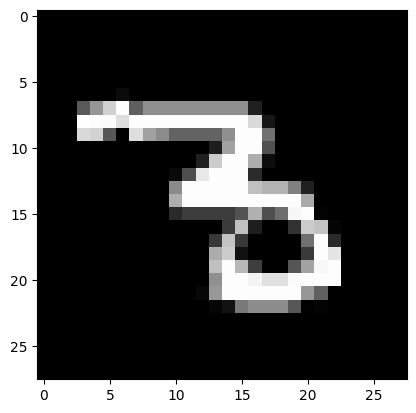

In [ ]:
image, label=trainset[30]
plt.imshow(image.squeeze(), cmap='gray')


In [ ]:
print("total images present in trainset ", len(trainset))

total images present in trainset  60000


#Load Dataset into Batches

In [ ]:
from torch.utils.data import DataLoader

#Make a grid of images.
from torchvision.utils import make_grid

In [ ]:
#While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting.
#DataLoader is an iterable that abstracts this complexity for us in an easy API.

trainloader= DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [ ]:
print('Total number of batches in trainloader: ', len(trainloader))

Total number of batches in trainloader:  938


In [ ]:
#We have loaded the dataset into the DataLoader and can iterate through the dataset as needed.
#Each iteration below returns a batch of images and labels
#1 batch contains 64 images

images, labels = next(iter(trainloader))
print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [ ]:
#show tensor images
# Parameters of make_grid: tensor – 4D mini-batch Tensor of shape (B x C x H x W) or a list of images all of the same size.
# nrow (– Number of images displayed in each row of the grid. The final grid size is (B / nrow, nrow).

def plot_images(img, no_of_images=8, size=(1, 28, 28)):
  unflat_img=img.detach().cpu()
  img_grid=make_grid(unflat_img[:no_of_images], nrow=4)
  plt.imshow(img_grid.permute(1, 2, 0).squeeze())
  plt.show()


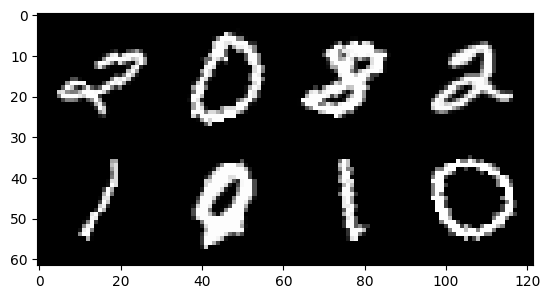

In [50]:
plot_images(images);

# Create Discriminator Network

In [ ]:
from torch import nn
from torchsummary import summary

Discriminator Network

Input : (batch_size, 1, 28, 28) #image is of gray scale so Channel=1
       
  
1. Conv2d( in_channels=1, out_channels=16, kernel_size=(3,3), stride=2)

   BatchNorm2d()

   LeakyReLU()


2. Conv2d( in_channels=16, out_channels=32, kernel_size=(5,5), stride=2)

   BatchNorm2d()

   LeakyReLU()
     

3. Conv2d( in_channels=32, out_channels=64, kernel_size=(5,5), stride=2)

   BatchNorm2d()

   LeakyReLU()


4. Flatten()

   Linear(in_features=64, out_features=1)

In [ ]:
def discriminator_block(in_channel, out_channel, kernel_size, stride):
  return nn.Sequential(
      nn.Conv2d(in_channel, out_channel, kernel_size, stride),
      nn.BatchNorm2d(out_channel),
      nn.LeakyReLU(0.2)
  )

###Conv2d:

The feature detector is a two-dimensional (2-D) array of weights, which represents part of the image. While they can vary in size, the filter size is typically a 3x3 matrix; this also determines the size of the receptive field. The filter is then applied to an area of the image, and a dot product is calculated between the input pixels and the filter. This dot product is then fed into an output array. Afterwards, the filter shifts by a stride, repeating the process until the kernel has swept across the entire image. The final output from the series of dot products from the input and the filter is known as a feature map, activation map, or a convolved feature.

###LeakyReLU:

Leaky ReLUs allow a small, positive gradient when the unit is not active, helping to mitigate the vanishing gradient problem.

f(x)=\begin{cases}x&{\text{if }}x>0,\\0.01x&{\text{otherwise}}.\end{cases}


 f'(x)=\begin{cases}1&{\text{if }}x>0,\\0.01&{\text{otherwise}}.\end{cases}


###BatchNormalization:

Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.

In [ ]:
#torch.nn.Module: Base class for all neural network modules.

class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator, self).__init__()
    self.n1=discriminator_block(1, 16, (3,3), 2)
    self.n2=discriminator_block(16, 32, (5,5), 2)
    self.n3=discriminator_block(32, 64, (5,5), 2)

    self.flatten=nn.Flatten()
    self.linear=nn.Linear(in_features=64, out_features=1)

  def forward (self, images):
    o1=self.n1(images)
    o2=self.n2(o1)
    o3=self.n3(o2)
    o4=self.flatten(o3)
    o5=self.linear(o4)

    return o5


In [ ]:
d_network=Discriminator()
d_network.to(device)

Discriminator(
  (n1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (n2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (n3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
summary(d_network, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

#Generator Network

Generator Network

Input: (batch_size, noise_dim)

Reshape input: (batch_size, channel, height, width)

1. ConvTranspose2d(in_channels=z_dim, out_channels=256, kernel_size=(3,3), stride=2)
  
  BatchNorm2d

  ReLU

2. ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=(4,4), stride=1)
  
  BatchNorm2d

  ReLU

3. ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(3,3), stride=2)
  
  BatchNorm2d

  ReLU

4. ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=(4,4), stride=2)
  
  Tanh



In [40]:
def generator_block(in_channel, out_channel, kernel_size, stride, final_block=False):
  if final_block==True:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channel, out_channel, kernel_size, stride),
        nn.Tanh()
    )
  return nn.Sequential(
      nn.ConvTranspose2d(in_channel, out_channel, kernel_size, stride),
      nn.BatchNorm2d(out_channel),
      nn.ReLU()
  )

In [41]:

class Generator(nn.Module):

  def __init__(self, noise_dim):
    super(Generator, self).__init__()
    self.noise_dim=noise_dim
    self.n1=generator_block(noise_dim, 256, (3,3), 2)
    self.n2=generator_block(256, 128, (4,4), 1)
    self.n3=generator_block(128, 64, (3,3), 2)
    self.n4=generator_block(64, 1, (4,4), 2, final_block=True)



  def forward (self, noise_vector):
    x=noise_vector.view(-1, self.noise_dim, 1, 1)
    o1=self.n1(x)
    o2=self.n2(o1)
    o3=self.n3(o2)
    o4=self.n4(o3)

    return o4

In [44]:
g_network=Generator(noise_dim)
g_network.to(device)
summary(g_network, input_size=(1, noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [45]:
# Replace random initialized weights to normal weights

def weights_init(m):
  if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
    nn.init.normal_(m.weight, 0.0, 0.02)
  if isinstance(m, nn.BatchNorm2d):
    nn.init.normal_(m.weight, 0.0, 0.02)
    nn.init.constant_(m.bias, 0)



In [46]:
d_network.apply(weights_init)
g_network.apply(weights_init)

Generator(
  (n1): Sequential(
    (0): ConvTranspose2d(64, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (n2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (n3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (n4): Sequential(
    (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
    (1): Tanh()
  )
)

#Loss Function

###BCEWithLogitsLoss

This loss combines a Sigmoid layer and the BCELoss in one single class. This version is more numerically stable than using a plain Sigmoid followed by a BCELoss as, by combining the operations into one layer, we take advantage of the log-sum-exp trick for numerical stability.

Inside BCEWithLogitsLoss sigmoid activation will apply on logits and then loss is computed between them.

Logits : output from linear layer also called raw outputs without any sigmoid or softmax activation

In [47]:
def real_loss(discriminator_predictions):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth=torch.ones_like(discriminator_predictions)
  loss = criterion(discriminator_predictions, ground_truth)
  return loss

def fake_loss(discriminator_predictions):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth=torch.zeros_like(discriminator_predictions)
  loss = criterion(discriminator_predictions, ground_truth)
  return loss


###Adam Optimizer

  for t in range(num_iterations):
  
      g = compute_gradient(x, y)
      
      m = beta_1 * m + (1 - beta_1) * g
      
      v = beta_2 * v + (1 - beta_2) * np.power(g, 2)
    
      m_hat = m / (1 - np.power(beta_1, t))
      
      v_hat = v / (1 - np.power(beta_2, t))
    
      w = w - step_size * m_hat / (np.sqrt(v_hat) + epsilon)

In [48]:
discriminator_optimizer=torch.optim.Adam(d_network.parameters(), lr=lr, betas=(beta_1, beta_2))
generator_optimizer=torch.optim.Adam(g_network.parameters(), lr=lr, betas=(beta_1, beta_2))

Epoch: 1 | Discriminator loss: 0.6828842759132385 | Generator loss: 0.6959937214851379


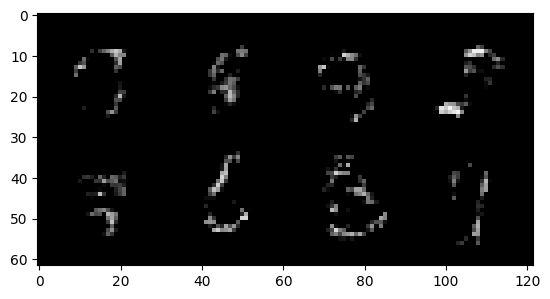

Epoch: 2 | Discriminator loss: 0.6126094460487366 | Generator loss: 0.7887667417526245


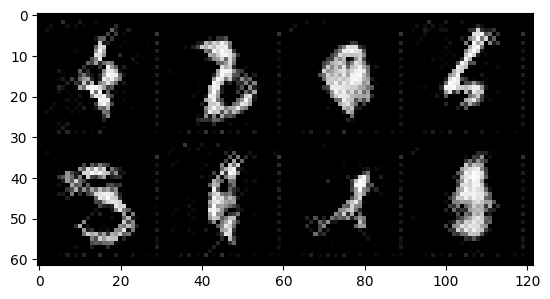

Epoch: 3 | Discriminator loss: 0.5882725715637207 | Generator loss: 0.8352233171463013


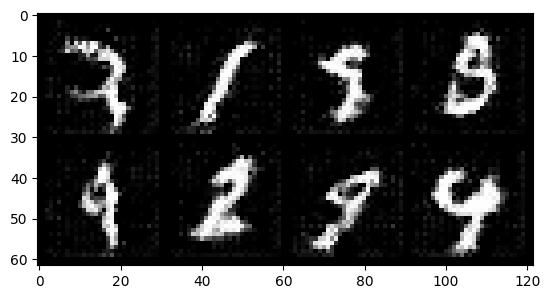

Epoch: 4 | Discriminator loss: 0.6288649439811707 | Generator loss: 0.8008979558944702


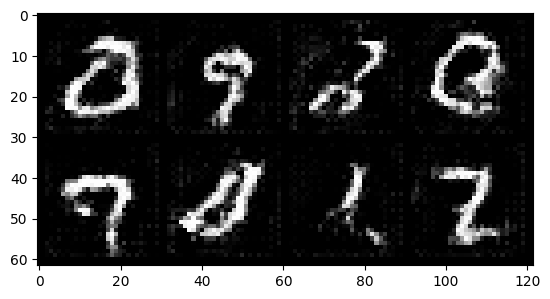

Epoch: 5 | Discriminator loss: 0.631313681602478 | Generator loss: 0.80605149269104


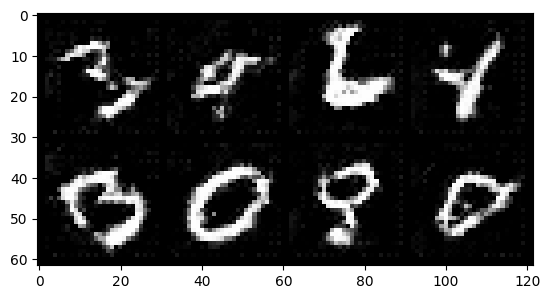

Epoch: 6 | Discriminator loss: 0.6395288705825806 | Generator loss: 0.8013055324554443


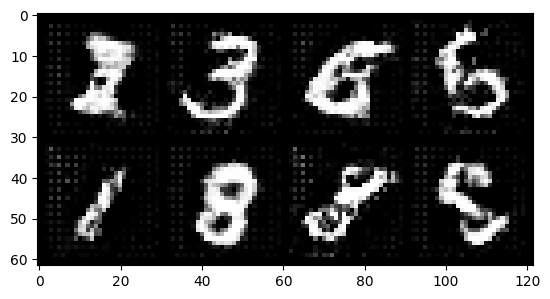

Epoch: 7 | Discriminator loss: 0.6474812626838684 | Generator loss: 0.7958895564079285


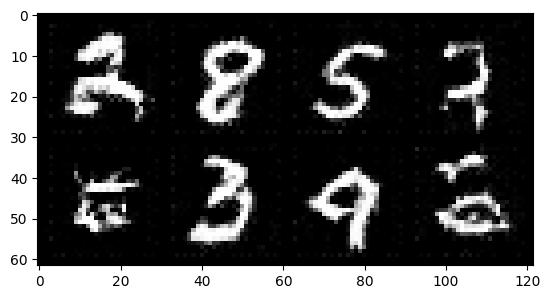

Epoch: 8 | Discriminator loss: 0.6529623866081238 | Generator loss: 0.7867984771728516


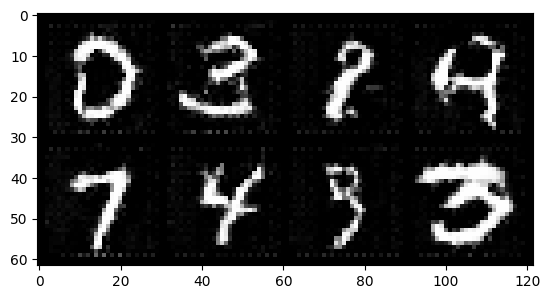

Epoch: 9 | Discriminator loss: 0.6574614644050598 | Generator loss: 0.7789910435676575


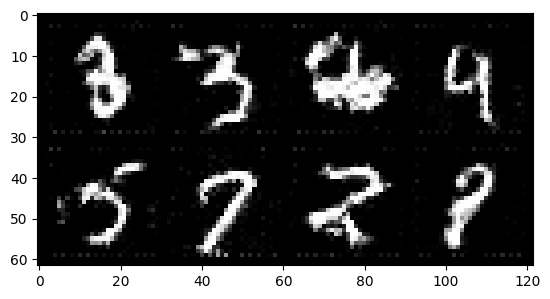

Epoch: 10 | Discriminator loss: 0.6589041352272034 | Generator loss: 0.7759037613868713


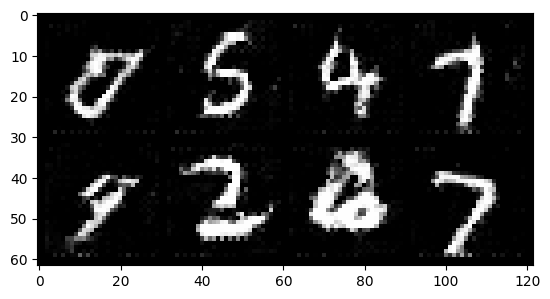

Epoch: 11 | Discriminator loss: 0.6610807180404663 | Generator loss: 0.7717928886413574


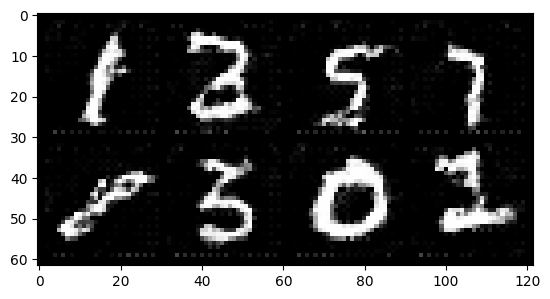

Epoch: 12 | Discriminator loss: 0.6612193584442139 | Generator loss: 0.7736151814460754


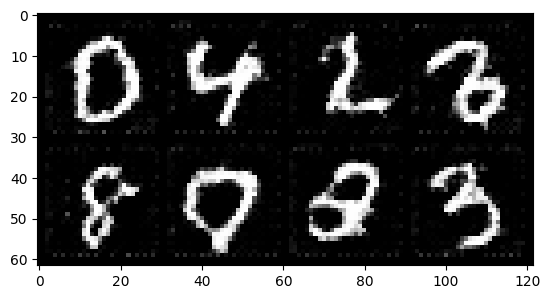

Epoch: 13 | Discriminator loss: 0.6617184281349182 | Generator loss: 0.771774172782898


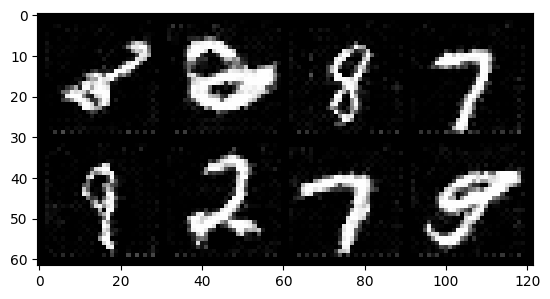

Epoch: 14 | Discriminator loss: 0.6621052026748657 | Generator loss: 0.769949197769165


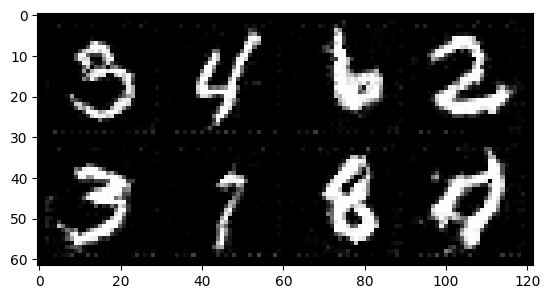

Epoch: 15 | Discriminator loss: 0.660444438457489 | Generator loss: 0.774039089679718


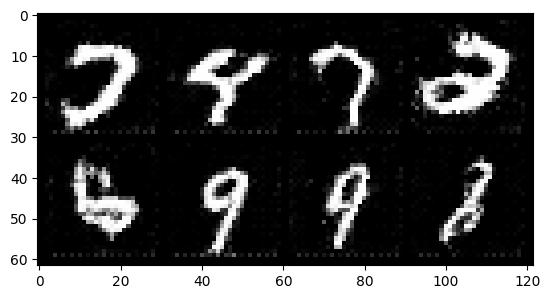

Epoch: 16 | Discriminator loss: 0.6580371260643005 | Generator loss: 0.7778255939483643


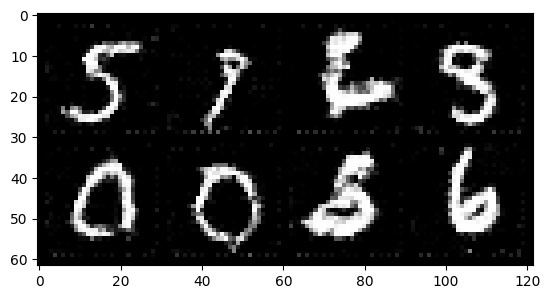

Epoch: 17 | Discriminator loss: 0.6560111045837402 | Generator loss: 0.7833319306373596


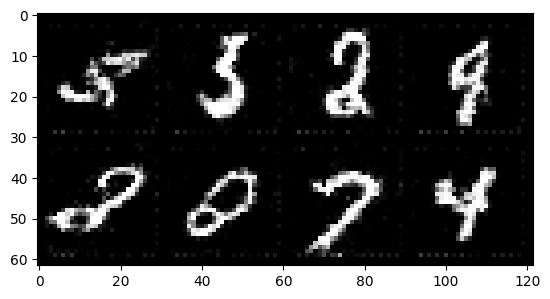

Epoch: 18 | Discriminator loss: 0.6525155305862427 | Generator loss: 0.7914537787437439


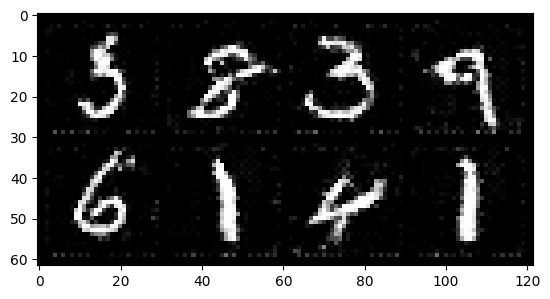

Epoch: 19 | Discriminator loss: 0.6513546705245972 | Generator loss: 0.7921008467674255


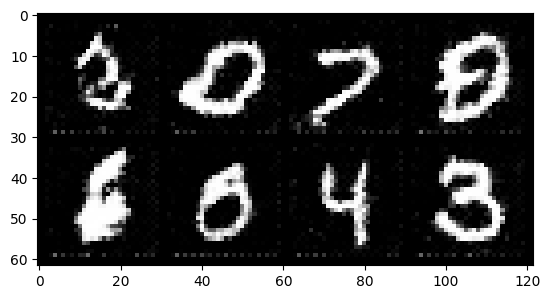

Epoch: 20 | Discriminator loss: 0.6475657224655151 | Generator loss: 0.8029378652572632


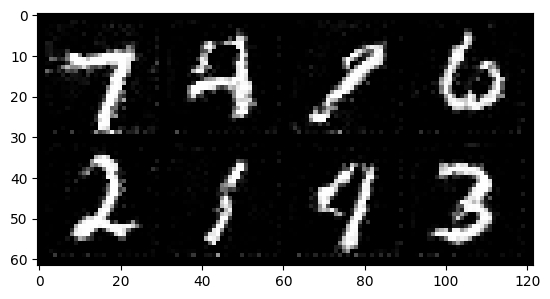

In [49]:
for i in range(epochs):
  total_discriminator_loss=0
  total_generator_loss=0

  for real_img, _ in trainloader:
    real_img = real_img.to(device)
    noise = torch.randn(batch_size, noise_dim, device=device)

    #find loss and update weights for discriminator
    discriminator_optimizer.zero_grad()

    fake_img = g_network(noise)
    discriminator_predictions = d_network(fake_img)
    discriminator_fake_loss = fake_loss(discriminator_predictions)

    discriminator_predictions = d_network(real_img)
    discriminator_real_loss = real_loss(discriminator_predictions)

    discriminator_loss = (discriminator_fake_loss+discriminator_real_loss)/2
    total_discriminator_loss += discriminator_loss
    discriminator_loss.backward()
    discriminator_optimizer.step()

    #find loss and update weights for generator
    generator_optimizer.zero_grad()

    noise = torch.randn(batch_size, noise_dim, device=device)

    fake_img = g_network(noise)
    discriminator_predictions = d_network(fake_img)
    generator_loss = real_loss(discriminator_predictions)
    total_generator_loss += generator_loss
    generator_loss.backward()
    generator_optimizer.step()

  avg_discriminator_loss = total_discriminator_loss/len(trainloader)
  avg_generator_loss = total_generator_loss/len(trainloader)

  print("Epoch: {} | Discriminator loss: {} | Generator loss: {}".format(i+1, avg_discriminator_loss, avg_generator_loss))

  plot_images(fake_img);





